In [141]:
import tensorflow as tf
import numpy as np
import h5py
import matplotlib.pyplot as plt
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')
from importlib import reload

In [2]:
import models.models as models
reload(models)
import utils.preprocessing as prepr
reload(prepr)

Using TensorFlow backend.


<module 'utils.preprocessing' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/preprocessing.py'>

In [277]:
#Data Samples
DATA_PATH = '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_data/events/'

TRAIN_NAME = 'qcd_sqrtshatTeV_13TeV_PU40_NEW_sideband'
filename_bg = DATA_PATH + TRAIN_NAME + '_parts/' + TRAIN_NAME + '_000.h5'
batch_size = 128
train_set_size = batch_size*50
nodes_n, feat_sz, particles_bg, A_bg, A_tilde_bg = prepr.prepare_data(filename_bg,train_set_size,0,train_set_size+1)
#BG test
_,_, particles_bg_test, A_bg_test, A_tilde_bg_test = prepr.prepare_data(filename_bg,5000,train_set_size+1,train_set_size+5000)

# BG validation
VALID_NAME = 'qcd_sqrtshatTeV_13TeV_PU40_NEW_EXT_sideband'
filename_bg_valid = DATA_PATH + VALID_NAME + '_parts/' + VALID_NAME + '_000.h5'
batch_size = 128
valid_set_size = batch_size*10
_,_, particles_bg_valid, A_bg_valid, A_tilde_bg_valid = prepr.prepare_data(filename_bg,valid_set_size,0,valid_set_size+1)


Number of jets = 12571
Number of constituents (nodes) = 100
Number of features = 3


/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/preprocessing.py:38: RuntimeWarning: divide by zero encountered in power
  D = np.nan_to_num(np.power(D,-0.5), posinf=0, neginf=0) # normalize (**-(1/2))


Number of jets = 9840
Number of constituents (nodes) = 100
Number of features = 3
Number of jets = 2518
Number of constituents (nodes) = 100
Number of features = 3
Number of jets = 9854
Number of constituents (nodes) = 100
Number of features = 3


In [283]:
#signal
SIG_MASS = '3.5'
SIG_NAME = 'RSGraviton_WW_NARROW_13TeV_PU40_'+SIG_MASS+'TeV_NEW'
filename_sig = DATA_PATH + SIG_NAME + '_parts/' + SIG_NAME + '_concat_001.h5'
_,_, particles_sig, A_sig, A_tilde_sig = prepr.prepare_data(filename_sig,5000,0,5000)

Number of jets = 9966
Number of constituents (nodes) = 100
Number of features = 3


/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/preprocessing.py:38: RuntimeWarning: divide by zero encountered in power
  D = np.nan_to_num(np.power(D,-0.5), posinf=0, neginf=0) # normalize (**-(1/2))


In [4]:
print(particles_bg.shape, A_tilde_bg.shape, A_bg.shape)

(6400, 100, 3) (6400, 100, 100) (6400, 100, 100)


# Autoencoder

In [270]:
gnn = models.GraphAutoencoder(nodes_n=nodes_n, feat_sz=feat_sz, activation=tf.nn.tanh)
gnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), run_eagerly=True)  #learning rate 0.001 worked

Model: "functional_87"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input_features (InputLa [(None, 100, 3)]     0                                            
__________________________________________________________________________________________________
encoder_input_adjacency (InputL [(None, 100, 100)]   0                                            
__________________________________________________________________________________________________
graph_convolution_80 (GraphConv (None, 100, 6)       42          encoder_input_features[0][0]     
                                                                 encoder_input_adjacency[0][0]    
__________________________________________________________________________________________________
graph_convolution_81 (GraphConv (None, 100, 8)       104         graph_convolution_80[

In [297]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, verbose=1),
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)]
gnn.fit((particles_bg, A_tilde_bg), A_bg, epochs=50, batch_size=128, validation_split=0.25, callbacks=callbacks)

Epoch 1/50
38/38 [==============================] - 4s 102ms/step - val_loss: 0.4406
Epoch 2/50
38/38 [==============================] - 3s 90ms/step - val_loss: 0.4406
Epoch 3/50
38/38 [==============================] - 4s 103ms/step - val_loss: 0.4406
Epoch 4/50
38/38 [==============================] - 4s 107ms/step - val_loss: 0.4406
Epoch 5/50
38/38 [==============================] - 4s 103ms/step - val_loss: 0.4406
Epoch 6/50
38/38 [==============================] - ETA: 0s
Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
38/38 [==============================] - 4s 97ms/step - val_loss: 0.4406
Epoch 00006: early stopping


## Predict BG and Sig

In [284]:
z_sig, A_pred_sig = gnn((particles_sig, A_tilde_sig))
z_bg_test, A_pred_bg_test = gnn((particles_bg_test, A_tilde_bg_test))
loss_signal_gnn = tf.math.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(A_sig, A_pred_sig), axis=(1,2)).numpy() #predicted adjecny, but not set to 0/1 yet
loss_bg_gnn = tf.math.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(A_bg_test, A_pred_bg_test), axis=(1,2)).numpy()

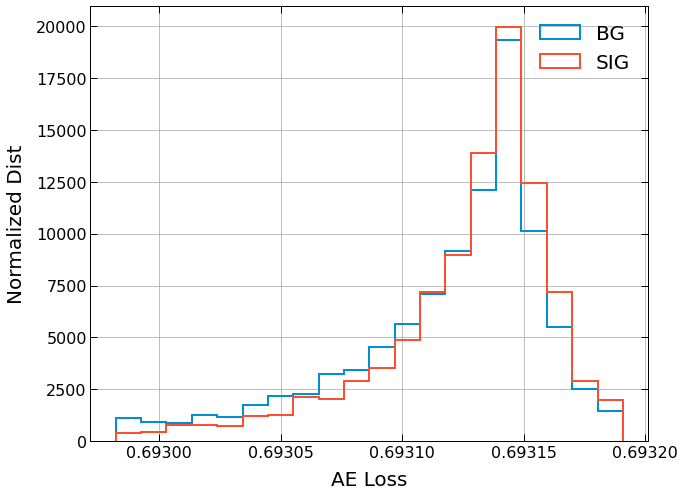

In [289]:
max_score = np.quantile(loss_signal_gnn,0.98)#,np.max(loss_bg_dist))
min_score = np.quantile(loss_bg_gnn,0.05)#,np.max(loss_bg_dist))
bins = 20
# plot BG
plt.figure()
plt.hist(loss_bg_gnn, bins=bins, label='BG', density=True, range=(min_score, max_score), 
         histtype='step', fill=False, linewidth=2)
plt.hist(loss_signal_gnn, bins=bins, label='SIG', density=True, range=(min_score, max_score), 
         histtype='step', fill=False, linewidth=2)
#plt.semilogy()
plt.xlabel("AE Loss")
plt.ylabel("Normalized Dist")
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

# GVAE

In [259]:
gvae = models.GraphVariationalAutoencoder(nodes_n=nodes_n, feat_sz=feat_sz, activation=tf.nn.tanh)
gvae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), run_eagerly=True) 

In [263]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, verbose=2),
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=2)] 
gvae.fit((particles_bg, A_tilde_bg), A_bg, epochs=30, batch_size=128, validation_data = ((particles_bg_valid, A_tilde_bg_valid),A_bg_valid), callbacks=callbacks) 

Epoch 1/30
50/50 [==============================] - 4s 74ms/step - loss: 0.4936 - loss_reco: 0.4628 - loss_latent: 0.0308 - val_loss: 0.5141 - val_loss_reco: 0.4858 - val_loss_latent: 0.0283
Epoch 2/30
50/50 [==============================] - 4s 73ms/step - loss: 0.4896 - loss_reco: 0.4623 - loss_latent: 0.0273 - val_loss: 0.5047 - val_loss_reco: 0.4795 - val_loss_latent: 0.0252
Epoch 3/30
50/50 [==============================] - 4s 77ms/step - loss: 0.4859 - loss_reco: 0.4616 - loss_latent: 0.0244 - val_loss: 0.5028 - val_loss_reco: 0.4803 - val_loss_latent: 0.0225
Epoch 4/30
50/50 [==============================] - 4s 74ms/step - loss: 0.4834 - loss_reco: 0.4615 - loss_latent: 0.0219 - val_loss: 0.5018 - val_loss_reco: 0.4815 - val_loss_latent: 0.0203
Epoch 5/30
50/50 [==============================] - 4s 71ms/step - loss: 0.4805 - loss_reco: 0.4607 - loss_latent: 0.0199 - val_loss: 0.4993 - val_loss_reco: 0.4808 - val_loss_latent: 0.0184
Epoch 6/30
50/50 [===========================

In [290]:
z_sig, z_mean_sig, z_log_var_sig, A_pred_sig = gvae((particles_sig, A_tilde_sig))
z_bg_test,z_mean_bg_test, z_log_var_bg_test, A_pred_bg_test = gvae((particles_bg_test, A_tilde_bg_test))
loss_signal_gvae = tf.math.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(A_sig, A_pred_sig), axis=(1,2)).numpy() #predicted adjecny, but not set to 0/1 yet
loss_bg_gvae = tf.math.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(A_bg_test, A_pred_bg_test), axis=(1,2)).numpy()


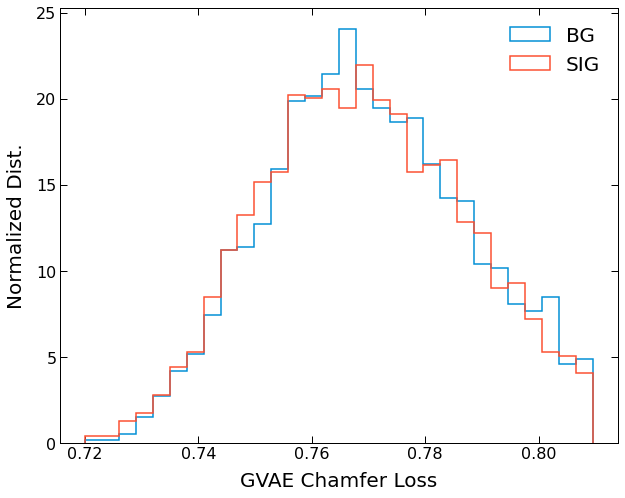

In [292]:
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')

max_score = np.quantile(loss_signal_gvae,0.95)#,np.max(loss_bg_dist))
min_score = np.min(loss_bg_gvae)#,np.max(loss_bg_dist))
bins = 30
# plot BG
plt.figure()
plt.hist(loss_bg_gvae, bins=bins, label='BG', density=True, range=(min_score, max_score), 
         histtype='step', fill=False, linewidth=1.5)
plt.hist(loss_signal_gvae, bins=bins, label='SIG', density=True, range=(min_score, max_score), 
         histtype='step', fill=False, linewidth=1.5)
#plt.semilogy()
plt.xlabel("GVAE Chamfer Loss")
plt.ylabel("Normalized Dist.")
plt.legend(loc='upper right')
plt.show()

# GCN VAE

In [5]:
def threeD_loss_manual(inputs, outputs):
    distances = np.sum(np.subtract(inputs[:,:,np.newaxis,:],outputs[:,np.newaxis,:,:])**2, axis=-1)
    min_dist_to_inputs = np.min(distances,axis=1)
    min_dist_to_outputs = np.min(distances,axis=2)
    return np.sum(min_dist_to_inputs,axis=1) + np.sum(min_dist_to_outputs,axis=1)



In [239]:
import models.losses as losses
reload(losses)
import models.models as models
reload(models)
import utils.preprocessing as prepr
reload(prepr)


<module 'utils.preprocessing' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/preprocessing.py'>

In [240]:
gcnvae = models.GCNVariationalAutoEncoder(nodes_n=nodes_n, feat_sz=feat_sz, activation=tf.nn.tanh,latent_dim=50,kl_warmup_time=10)
gcnvae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), run_eagerly=True)

100
Model: "functional_77"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input_features (InputLa [(None, 100, 3)]     0                                            
__________________________________________________________________________________________________
encoder_input_adjacency (InputL [(None, 100, 100)]   0                                            
__________________________________________________________________________________________________
graph_convolution_68 (GraphConv (None, 100, 6)       42          encoder_input_features[0][0]     
                                                                 encoder_input_adjacency[0][0]    
__________________________________________________________________________________________________
graph_convolution_69 (GraphConv (None, 100, 2)       26          graph_convolution

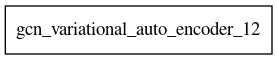

In [241]:
tf.keras.utils.plot_model(gcnvae, show_shapes=True)

In [242]:
custom_callback = models.KLWarmupCallback()
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, verbose=2),
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=2),custom_callback] 
gcnvae.fit(particles_bg, A_tilde_bg, epochs=30, batch_size=128, validation_data = ((particles_bg_valid, A_tilde_bg_valid)), callbacks=callbacks) 

Epoch 1/30
50/50 [==============================] - 5s 101ms/step - loss: 1.2190 - loss_reco: 1.2190 - loss_latent: 2.1406 - beta_kl_warmup: 0.0000e+00 - val_loss: 0.9559 - val_loss_reco: 0.9559 - val_loss_latent: 7.1620s - loss: 1.4245 - loss_reco: 1.4245 - loss_latent: 1.1065 - beta_kl_warmup: 0. - ETA: 1s - loss: 1.3701 - loss_reco: 1.3701 - loss_latent: 1.1002 -  - ETA: 0s - loss: 1.2589 - loss_reco: 1.2589 - loss_latent: 1.6247 - beta_kl_warmup
Epoch 2/30
50/50 [==============================] - 5s 100ms/step - loss: 1.3102 - loss_reco: 1.0075 - loss_latent: 0.3027 - beta_kl_warmup: 0.1000 - val_loss: 0.9467 - val_loss_reco: 0.9453 - val_loss_latent: 0.0014_warmup - ETA: 2s - loss: 1.7303 - loss_rec
Epoch 3/30
50/50 [==============================] - 5s 100ms/step - loss: 0.9490 - loss_reco: 0.9484 - loss_latent: 3.1488e-04 - beta_kl_warmup: 0.2000 - val_loss: 0.9209 - val_loss_reco: 0.9208 - val_loss_latent: 1.9719e-0560 - loss_reco: 0.9451 - loss_latent: 4.3674e-04 - beta_kl_war

In [157]:
loaded_1 = tf.keras.models.load_model(
    "output_model_saved_003", custom_objects={"GCNVariationalAutoEncoder": models.GCNVariationalAutoEncoder}
)


In [293]:
#Predict

#model = loaded_1
model = gcnvae

features_out_bg_test, z_bg_test, z_mean_bg_test, z_log_var_bg_test = model((particles_bg_test, A_tilde_bg_test))
features_out_bg_test = features_out_bg_test.numpy().astype('float32')
loss_bg = threeD_loss_manual(particles_bg_test.astype('float32'),features_out_bg_test)

features_out_sig, z_sig, z_mean_sig, z_log_var_sig = model((particles_sig, A_tilde_sig))
features_out_sig = features_out_sig.numpy().astype('float32')
loss_signal = threeD_loss_manual(particles_sig.astype('float32'),features_out_sig)

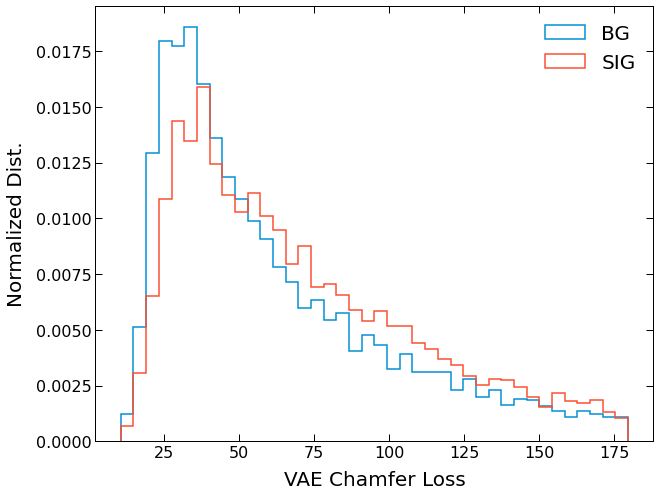

In [294]:
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')

max_score = np.quantile(loss_signal,0.9)#,np.max(loss_bg_dist))
min_score = np.min(loss_bg)#,np.max(loss_bg_dist))
bins = 40
# plot BG
plt.figure()
plt.hist(loss_bg, bins=bins, label='BG', density=True, range=(min_score, max_score), 
         histtype='step', fill=False, linewidth=1.5)
plt.hist(loss_signal, bins=bins, label='SIG', density=True, range=(min_score, max_score), 
         histtype='step', fill=False, linewidth=1.5)
#plt.semilogy()
plt.xlabel("VAE Chamfer Loss")
plt.ylabel("Normalized Dist.")
plt.legend(loc='upper right')
plt.show()

In [246]:
print(np.quantile(loss_bg,0.8),np.quantile(loss_signal,0.8))

114.27671051025393 120.3024154663086


In [184]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
sys.path.append(os.path.abspath(os.path.join('../vande/')))
sys.path.append(os.path.abspath(os.path.join('../pofah/')))
sys.path.append(os.path.abspath(os.path.join('../sarewt/')))

In [228]:
import vande.analysis.analysis_roc as ar
reload(ar)

<module 'vande.analysis.analysis_roc' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py'>

In [295]:
neg_class_losses = [loss_bg.tolist(),loss_bg_gnn.tolist(),loss_bg_gvae.tolist()]
pos_class_losses = [loss_signal.tolist(),loss_signal_gnn.tolist(),loss_signal_gvae.tolist()]

In [296]:
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')
ar.plot_roc( neg_class_losses, pos_class_losses, legend=['GCN VAE','GAE','GVAE'], title='ROC ', plot_name='ROC_text', fig_dir='figs/',log_x=False )

/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py:33: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")")
/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py:33: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")")
/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py:33: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")")


[0.55944858, 0.5544533, 0.48788074000000003]